Astronomy has a rich history of data collection and recording. Data about and from celestial bodies are collected using various telescopes, photon detectors, and particle detectors. Although the entire electromagnetic spectrum is important, most observational data come from the visible/infrared (wavelengths from 400 nm to 1 mm) and radio (wavelengths from 1 cm to 1 km) portions of the spectrum.

Co-authorship network is a group of researchers connected in pairs to represent relationships. Two researchers are considered related when they have published papers in journals and conferences and published and edited books together. In such networks, researchers are called "nodes" or "nodes", and connections are called "edges". Co-authorship networks are an important class of social networks. Analysis of these networks reveals characteristics of academic communities that contribute to understanding collaboration and identifying prominent researchers.

The focus of this notebook is to analysis of structural properties in co-authored networks in astrophysics using centrality measures. 

In [1]:
!pip install pyvis
!pip install pyLDAvis

  Preparing metadata (setup.py) ... done
  Created wheel for pyvis: filename=pyvis-0.2.1-py3-none-any.whl size=23688 sha256=e6d1eff163683120a0281c5c58b518f0c10f98f89d8e610ee5bc95d71ed65cb3
  Stored in directory: /root/.cache/pip/wheels/2a/8f/04/6340d46afc74f59cc857a594ca1a2a14a1f4cbd4fd6c2e9306
Successfully built pyvis


In [2]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import sys
import ast

import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns

import dask.bag as db

import networkx as nx
from networkx.algorithms.components.connected import connected_components

import json
import dask.bag as db
import os

sys.path.append("..")

from pathlib import Path

import json

from itertools import combinations
from collections import Counter
from itertools import chain
import random

from tqdm.notebook import tqdm, trange
import time    # to be used in loop iterations

import multiprocessing
import smart_open

from gensim.models.word2vec import Word2Vec

import pyvis

from pyvis.network import Network

from IPython.core.display import display, HTML

In [3]:
ai_category_list=['astro-ph']
records=db.read_text("../input/arxiv/arxiv-metadata-oai-snapshot.json").map(lambda x:json.loads(x))
ai_docs = (records.filter(lambda x:any(ele in x['categories'] for ele in ai_category_list)==True))
get_metadata = lambda x: {'id': x['id'],
                  'title': x['title'],
                  'category':x['categories'],
                  'abstract':x['abstract'],
                 'version':x['versions'][-1]['created'],
                         'doi':x["doi"],
                         'authors_parsed':x['authors_parsed']}

data=ai_docs.map(get_metadata).to_dataframe().compute()

data.to_excel("Astro_ArXiv_Papers.xlsx",index=False,encoding="utf-8")

In [4]:
# Concatenate the author first and last names
data['num_authors']=data['authors_parsed'].apply(lambda x:len(x))

data['authors']=data['authors_parsed'].apply(lambda authors:[(" ".join(author)).strip() for author in authors])
data.head()

,id,title,category,abstract,version,doi,authors_parsed,num_authors,authors
0,0704.0009,"The Spitzer c2d Survey of Large, Nearby, Inste...",astro-ph,We discuss the results from the combined IRA...,"Mon, 2 Apr 2007 19:41:34 GMT",10.1086/518646,"[[Harvey, Paul, ], [Merin, Bruno, ], [Huard, T...",7,"[Harvey Paul, Merin Bruno, Huard Tracy L., Reb..."
1,0704.0017,Spectroscopic Observations of the Intermediate...,astro-ph,Results from spectroscopic observations of t...,"Sat, 31 Mar 2007 07:38:48 GMT",10.1111/j.1365-2966.2007.11762.x,"[[Mhlahlo, Nceba, ], [Buckley, David H., ], [D...",6,"[Mhlahlo Nceba, Buckley David H., Dhillon Vikr..."
2,0704.0023,ALMA as the ideal probe of the solar chromosphere,astro-ph,"The very nature of the solar chromosphere, i...","Sat, 31 Mar 2007 11:42:13 GMT",10.1007/s10509-007-9626-1,"[[Loukitcheva, M. A., ], [Solanki, S. K., ], [...",3,"[Loukitcheva M. A., Solanki S. K., White S.]"
3,0704.0044,Astrophysical gyrokinetics: kinetic and fluid ...,astro-ph nlin.CD physics.plasm-ph physics.spac...,We present a theoretical framework for plasm...,"Sat, 9 May 2009 19:26:10 GMT",10.1088/0067-0049/182/1/310,"[[Schekochihin, A. A., , Oxford], [Cowley, S. ...",7,"[Schekochihin A. A. Oxford, Cowley S. C. Cul..."
4,0704.0048,Inference on white dwarf binary systems using ...,gr-qc astro-ph,We report on the analysis of selected single...,"Tue, 3 Apr 2007 22:26:37 GMT",10.1088/0264-9381/24/19/S17,"[[Stroeer, Alexander, ], [Veitch, John, ], [Ro...",14,"[Stroeer Alexander, Veitch John, Roever Christ..."


In [5]:
data['DateTime']=pd.to_datetime(data['version'])
data['Day'] = data['DateTime'].dt.day
data['Month'] = data['DateTime'].dt.month
data['Year'] = data['DateTime'].dt.year

In [6]:
# Filter data (2020 to 2021)

data = data[data['Year'].between(2020, 2021)]

In [7]:
# This project focuses on individual author structure and development; whereas LIGO or VIRGO would not be taken into account.
data = data[data['num_authors'] <= 6]

In [8]:
data['author_pairs']=data['authors'].apply(lambda x:list(combinations(x, 2)))

In [9]:
def flattenList(nested_list):
    flat_list = [item for sublist in nested_list for item in sublist]
    return flat_list

In [10]:
astro_authors=pd.DataFrame(flattenList(data['authors'].tolist())).rename(columns={0:'authors'})
papers_by_authors=astro_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors.shape

(39422, 2)

In [11]:
papers_by_authors['Number of Papers Published'].describe()

count    39422.000000
mean         1.970549
std          2.134198
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         78.000000
Name: Number of Papers Published, dtype: float64

In [12]:
# Keeping Authors who have published more than 2 Papers
nodes_to_keep=papers_by_authors.loc[papers_by_authors['Number of Papers Published']>2,'authors'].tolist()
len(nodes_to_keep)

7719

## Generating the Edges of the Co-Author Network

In [13]:
authors_pairs=data['author_pairs'].tolist()
authors_edge_list=[item for sublist in authors_pairs for item in sublist]
authors_weighted_edge_list=list(Counter(authors_edge_list).items())
authors_weighted_edge_list=[(row[0][0],row[0][1],row[1]) for idx,row in enumerate(authors_weighted_edge_list)]
authors_weighted_edge_list[0:10]

[('Trenti M.  Stsci', 'Stiavelli M.  Stsci Jhu', 1),
 ('Fairbairn Malcolm', 'Rashba Timur', 1),
 ('Fairbairn Malcolm', 'Troitsky Sergey', 1),
 ('Rashba Timur', 'Troitsky Sergey', 1),
 ('Singal Tanmay', 'Singal Ashok k.', 1),
 ('Liu Wen-Fei  1 and 2', 'Niu Jing  2\n  and 1', 1),
 ('Liu Wen-Fei  1 and 2', 'Li Juan  2\n  and 1', 1),
 ('Liu Wen-Fei  1 and 2', 'Zhang Tong-Jie  2\n  and 1', 1),
 ('Niu Jing  2\n  and 1', 'Li Juan  2\n  and 1', 1),
 ('Niu Jing  2\n  and 1', 'Zhang Tong-Jie  2\n  and 1', 1)]

In [14]:
G1=nx.Graph()
G1.add_weighted_edges_from(authors_weighted_edge_list)
print(len(G1.nodes()))

38474


In [15]:
sub_g=nx.subgraph(G1,nodes_to_keep)
G=nx.Graph(sub_g)
print(len(G.nodes()))
isolated_node=nx.isolates(G)
len(list(isolated_node))

7651


305

In [16]:
G.remove_nodes_from(list(nx.isolates(G)))
len(G.nodes)

7346

In [17]:
del G1, sub_g

In [18]:
print("Number of Nodes in Author Graph ",len(G.nodes()))
print("Number of Edges in AUthor Graph ",len(G.edges()))

Number of Nodes in Author Graph  7346
Number of Edges in AUthor Graph  19665


In [19]:
def getRandomWalk(graph,node,length_of_random_walk):
    start_node=node
    current_node=start_node
    random_walk=[node]
    for i in range(0,length_of_random_walk):
        current_node_neighbours=list(graph.neighbors(current_node))
        chosen_node=random.choice(current_node_neighbours)
        current_node=chosen_node
        random_walk.append(current_node)
    return random_walk

#### For every Node in the Graph, get randomwalks . 
#### For each node, get 10 random walks 

In [20]:
num_sampling=10
random_walks=[]
length_of_random_walk=10
for node in tqdm(G.nodes(),desc="Iterating Nodes"):
    
    for i in range(0,num_sampling):
        random_walks.append(getRandomWalk(G,node,length_of_random_walk))

Iterating Nodes:   0%|          | 0/7346 [00:00<?, ?it/s]

In [21]:
deepwalk_model=Word2Vec(sentences=random_walks,window=5,sg=1,negative=5,vector_size=128,epochs=20,compute_loss=True)

In [22]:
deepwalk_model.save("deepwalk1.model")

In [23]:
def getSimilarNodes(model,node):
    similarity=model.wv.most_similar(node)
    similar_nodes=pd.DataFrame()
    similar_nodes['Similar_Node']=[row[0] for i,row in enumerate(similarity)]
    similar_nodes['Similarity_Score']=[row[1] for i,row in enumerate(similarity)]
    similar_nodes['Source_Node']=node
    return similar_nodes

In [24]:
ai_authors=pd.DataFrame(flattenList(data['authors'].tolist())).rename(columns={0:'authors'})
papers_by_authors=ai_authors.groupby(['authors']).size().reset_index().rename(columns={0:'Number of Papers Published'}).sort_values("Number of Papers Published",ascending=False)
papers_by_authors

,authors,Number of Papers Published
19922,Loeb Abraham,78
38194,Zhang Bing,42
9681,Federrath Christoph,35
4823,Capozziello Salvatore,35
31931,"Soker Noam Technion, Israel",33
...,...,...
16061,Kannike Kristjan,1
16058,Kannan Gokul,1
16057,Kann D. Alexander,1
16055,Kankiewicz Paweł,1


In [25]:
def getCoAuthorshipNetwork(graph,initial_nodes):
    total_neighbours=0
    nodes_set=[initial_nodes]
    for node in initial_nodes:
        #print(node)
        neighbours=list(graph.neighbors(node))
        total_neighbours=total_neighbours+len(neighbours)
        
        nodes_set.append(neighbours)
    print(total_neighbours)
    nodes_set=flattenList(nodes_set)
    return list(set(nodes_set))

In [26]:
coauthor_nodes=getCoAuthorshipNetwork(G,papers_by_authors['authors'].tolist()[4:10])
print("Number of CoAuthor Nodes ",len(coauthor_nodes))

129
Number of CoAuthor Nodes  126


In [27]:
coauthor_subgraph=nx.subgraph(G,coauthor_nodes)
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  275


In [28]:
nx.write_gexf(coauthor_subgraph, "CoAuthor_Subgraph_Author4to10.gexf")

In [29]:
print("number of edges in the CoAuthor Subgraph ",len(coauthor_subgraph.edges()))

number of edges in the CoAuthor Subgraph  275


In [30]:
pyvis_nt=Network(notebook=True,height='800px', width='100%',heading='')

print("Creating PyVis from NetworkX")
pyvis_nt.from_nx(coauthor_subgraph)

print("Saving PyVis Graph")
pyvis_nt.show("Author4to10_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph


## Degree Centrality
The degtee of a node is the number oof other nodes to which it is connected
It is calculated by taking the degree of the node and dividing by n-1 where n is the number of nodes in G

In [31]:
degree_centrality = nx.degree_centrality(G)

In [32]:
# Top 10
counter = 0
for w in sorted(degree_centrality, key = degree_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 21:
        break
    print(w,"{:0.5f}".format(degree_centrality[w]))

Krumholz Mark R. 0.00504
Zhang Bing 0.00490
Nishimichi Takahiro 0.00449
Ho Luis C. 0.00449
Villaescusa-Navarro Francisco 0.00436
Li Hui 0.00436
Murase Kohta 0.00422
Quataert Eliot 0.00422
Berti Emanuele 0.00408
Gerosa Davide 0.00408
Silk Joseph 0.00408
Spergel David N. 0.00408
Loeb Abraham 0.00408
Metzger Brian D. 0.00395
Perets Hagai B. 0.00395
Wandelt Benjamin D. 0.00381
Ramirez-Ruiz Enrico 0.00381
Viel Matteo 0.00368
Belokurov Vasily 0.00368
Yoshida Naoki 0.00368


# Closeness Centrality
Closeness centrality measures the mean distance from one node to any other node. The more central a node is, the closer it is to all the other nodes. The closeness of a node is typically referred to in its normalized form

In [33]:
closeness_centrality = nx.closeness_centrality(G)

In [34]:
# Top 10
counter = 0
for w in sorted(closeness_centrality, key = closeness_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 23:
        break
    print(w,"{:0.5f}".format(closeness_centrality[w]))

Loeb Abraham 0.18321
Ramirez-Ruiz Enrico 0.18053
Metzger Brian D. 0.17729
Toonen Silvia 0.17697
Safarzadeh Mohammadtaher 0.17628
Quataert Eliot 0.17625
Kremer Kyle 0.17607
Vogelsberger Mark 0.17606
Silk Joseph 0.17605
Leigh Nathan W. C. 0.17586
Federrath Christoph 0.17561
Kocsis Bence 0.17538
Perets Hagai B. 0.17531
Hernquist Lars 0.17522
Perna Rosalba 0.17519
Krumholz Mark R. 0.17495
Fragione Giacomo 0.17459
Yoshida Naoki 0.17453
Burkhart Blakesley 0.17432
Vagnozzi Sunny 0.17408
Villaescusa-Navarro Francisco 0.17385
Beniamini Paz 0.17371


node Mukherjee Suvodip as the highest closeness centrality, which means that it is closest to the most nodes than all the other nodes.

# Betweenness Centrality
It quantifies the number of times a node acts as a bridge along the shortest path between two other nodes
In thids conception, vectices that have a high probability to occur on a randomly chosen shortest path between two randomly chosen verticles have a high betweenness

In [35]:
betweenness_centrality = nx.betweenness_centrality(G)

In [36]:
# Top 10
counter = 0
for w in sorted(betweenness_centrality, key = betweenness_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 23:
        break
    print(w,"{:0.5f}".format(betweenness_centrality[w]))

Krumholz Mark R. 0.02515
Loeb Abraham 0.02307
Zhang Bing 0.02126
Silk Joseph 0.02059
Li Hui 0.01982
Janka H. -T. 0.01803
Goriely S. 0.01780
Ireland Michael J. 0.01768
Siess L. 0.01733
Van Winckel H. 0.01544
Omukai Kazuyuki 0.01513
Sukhbold Tuguldur 0.01507
Ho Luis C. 0.01490
Ramirez-Ruiz Enrico 0.01477
Kasen Daniel 0.01445
Kuiper Rolf 0.01442
Vagnozzi Sunny 0.01423
Li Xiaolei 0.01407
Bujarrabal V. 0.01399
Yoshida Naoki 0.01392
Zhang Jun 0.01353
Metzger Brian D. 0.01351


# Eigenvector Centrality
A node is high in eigenvector centrality if it is connected to many other nodes who are themselves well connected.
Eigenvector centrality for each node is simply calculated as the proportional eigenvector values of the eigenvector with the largest eigenvector

In [37]:
eigenvector_centrality = nx.eigenvector_centrality(G,max_iter=500)

In [38]:
# Top 10
counter = 0
for w in sorted(eigenvector_centrality, key = eigenvector_centrality.get, reverse = True):
    counter = counter + 1
    if counter == 23:
        break
    print(w,"{:0.5f}".format(eigenvector_centrality[w]))

Villaescusa-Navarro Francisco 0.20605
Spergel David N. 0.18685
Nishimichi Takahiro 0.13690
Ho Shirley 0.12665
Nelson Dylan 0.12613
Hernquist Lars 0.12550
Wandelt Benjamin D. 0.11510
Pillepich Annalisa 0.11269
Philcox Oliver H. E. 0.10183
Kamionkowski Marc 0.10146
Vogelsberger Mark 0.09474
Omukai Kazuyuki 0.09277
Loeb Abraham 0.09151
Yoshida Naoki 0.09060
Takada Masahiro 0.08989
Berti Emanuele 0.08979
Kocsis Bence 0.08401
Bernal José Luis 0.08200
Sherwin Blake D. 0.07992
Bose Sownak 0.07967
Kremer Kyle 0.07942
Hadzhiyska Boryana 0.07933


In [39]:
Silk_nodes = getCoAuthorshipNetwork(G,['Silk Joseph'])
Silk_network = nx.subgraph(G,Silk_nodes)
print("Number of Nodes in Silk Network ", len(Silk_network.nodes()))
print("Number of Edges in Silk Network ", len(Silk_network.edges()))

30
Number of Nodes in Silk Network  31
Number of Edges in Silk Network  61


In [40]:
Silk_nt=Network(notebook=True,height='800px', width='100%',heading='Silk Network')

print("Creating PyVis from NetworkX")
Silk_nt.from_nx(Silk_network)
Silk_nt.toggle_physics(True)
print("Saving PyVis Graph")

Silk_nt.show_buttons()
Silk_nt.show("Silk_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph


In [41]:
data['is_SJ']=data['authors'].apply(lambda x:1 if "Silk Joseph" in x else 0)
SJ_papers=data[data['is_SJ']==1]
SJ_papers=SJ_papers.reset_index(drop=True)

print("Number of Papers by Silk Joseph on Arxiv is ",SJ_papers.shape[0])

Number of Papers by Silk Joseph on Arxiv is  33


In [42]:
print("The First Paper published by Silk Joseph was in ",min(SJ_papers['DateTime']))
print("The Recent Paper published by Silk Joseph was in  ",max(SJ_papers['DateTime']))

The First Paper published by Silk Joseph was in  2020-01-04 21:30:27+00:00
The Recent Paper published by Silk Joseph was in   2021-12-21 19:48:26+00:00


In [43]:
import nltk
from nltk.corpus import stopwords

In [44]:
def removeStopWords(text,stop_words):
    words=text.split()
    filtered_words=[word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [45]:
titles=SJ_papers['title'].tolist()
stop_words = set(stopwords.words('english')) 
titles=[title.lower() for title in titles] ### Lower Casing the Title
titles=[removeStopWords(title,stop_words) for title in titles]

In [46]:
def generateNGram(text,n=2):
    tokens=text.split(" ")
    ngrams = zip(*[tokens[i:] for i in range(n)])
    n_grams= ["_".join(ngram) for ngram in ngrams]
    n_grams=[ngram for ngram in n_grams if not ngram.startswith("_")]
    n_grams=[ngram for ngram in n_grams if not ngram.endswith("_")]
    return n_grams

def getMostCommon(reviews_list,topn=20):
    reviews=" ".join(reviews_list)
    tokenised_reviews=reviews.split(" ")
    freq_counter=Counter(tokenised_reviews)
    return freq_counter.most_common(topn)

In [47]:
bigrams_list=[" ".join(generateNGram(title,2)) for title in titles]
topn=10
top_bigrams=getMostCommon(bigrams_list,topn=topn)
top_bigrams_df=pd.DataFrame()
top_bigrams_df['words']=[val[0] for val in top_bigrams]
top_bigrams_df['Frequency']=[val[1] for val in top_bigrams]
px.bar(data_frame=top_bigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Bigrams in Papers published by Silk Joseph")

In [48]:
trigrams_list=[" ".join(generateNGram(title.replace(":",""),3)) for title in titles]
topn=10
top_trigrams=getMostCommon(trigrams_list,topn=topn)
top_trigrams_df=pd.DataFrame()
top_trigrams_df['words']=[val[0] for val in top_trigrams]
top_trigrams_df['Frequency']=[val[1] for val in top_trigrams]
top_trigrams_df=top_trigrams_df[top_trigrams_df["words"]!=""]
px.bar(data_frame=top_trigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Trigrams in Papers published by Silk Joseph")

In [49]:
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning:

invalid escape sequence \d



In [50]:
def tokenise(sentences):
    return [gensim.utils.simple_preprocess(sentence, deacc=True,max_len=50) for sentence in sentences]

In [51]:
tokenised_sentences=tokenise(SJ_papers['title'].tolist())
tokenised_sentences[0]

['detectability',
 'of',
 'gravitational',
 'waves',
 'from',
 'the',
 'coalescence',
 'of',
 'massive',
 'primordial',
 'black',
 'holes',
 'with',
 'initial',
 'clustering']

In [52]:
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [53]:
def lemmatise(sentence,stop_words,allowed_postags=None):
    doc=nlp(sentence)
    #print(sentence)
    if allowed_postags!=None:
        tokens = [token.lemma_ for token in doc if (token.pos_ in allowed_postags) and (token.text not in stop_words)]
    if allowed_postags==None:
        tokens= [token.lemma_ for token in doc if (token.text not in stop_words)]
    return tokens

In [54]:
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [55]:
sentences=[" ".join(tokenised_sentence) for tokenised_sentence in tokenised_sentences]
lemmatised_sentences=[lemmatise(sentence,stop_words) for sentence in sentences]
lemmatised_sentences[0]

['detectability',
 'gravitational',
 'wave',
 'coalescence',
 'massive',
 'primordial',
 'black',
 'hole',
 'initial',
 'clustering']

In [56]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(lemmatised_sentences,min_count=2) 
trigram = gensim.models.Phrases(bigram[lemmatised_sentences],min_count=2)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [57]:
bigrams_words=[bigram_mod[sentence] for sentence in lemmatised_sentences]

trigrams_words=[trigram_mod[sentence] for sentence in bigrams_words]

In [58]:
id2word = corpora.Dictionary(trigrams_words)
corpus = [id2word.doc2bow(text) for text in trigrams_words]
[(id2word[id], freq) for id, freq in corpus[0]] 

[('clustering', 1),
 ('coalescence', 1),
 ('detectability', 1),
 ('gravitational_wave', 1),
 ('initial', 1),
 ('massive', 1),
 ('primordial_black_hole', 1)]

In [59]:
def compute_coherence_values(id2word, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

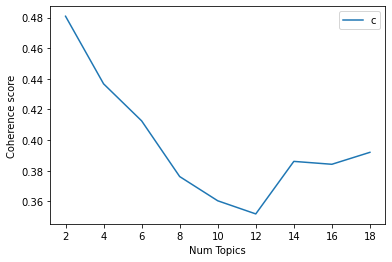

In [60]:
models,coherence=compute_coherence_values(id2word,corpus,trigrams_words,limit=20,start=2,step=2)
x = range(2, 20, 2)
plt.plot(x, coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [61]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [62]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.027*"stochastic_gravitational" + 0.027*"wave_background" + '
  '0.020*"primordial_black_hole" + 0.019*"black_hole" + 0.015*"astrophysical" '
  '+ 0.015*"galaxy" + 0.015*"primordial" + 0.011*"binary" + 0.011*"neutron" + '
  '0.011*"burst"'),
 (1,
  '0.028*"gravitational_wave" + 0.025*"primordial_black_hole" + 0.019*"star" + '
  '0.018*"dark_matter" + 0.018*"merger" + 0.016*"binary" + 0.016*"impact" + '
  '0.016*"scale" + 0.012*"rate" + 0.012*"implication"')]


In [63]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=trigrams_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -5.516405186348635

Coherence Score:  0.48082485689719523


In [64]:
def format_topics_sentences(texts,ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [65]:
df_topic_sents_keywords = format_topics_sentences(SJ_papers['title'].tolist(),ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9890,"gravitational_wave, primordial_black_hole, sta...",Detectability of Gravitational Waves from the ...
1,1,1.0,0.9848,"gravitational_wave, primordial_black_hole, sta...",Evolution of primordial black hole spin due to...
2,2,1.0,0.9890,"gravitational_wave, primordial_black_hole, sta...",Multi-messenger tests of gravity with weakly l...
3,3,1.0,0.9903,"gravitational_wave, primordial_black_hole, sta...",Probing the theory of gravity with gravitation...
4,4,1.0,0.9935,"gravitational_wave, primordial_black_hole, sta...",Cusp-to-core transition in low-mass dwarf gala...
5,5,0.0,0.9917,"stochastic_gravitational, wave_background, pri...",Embedding globular clusters in dark matter min...
6,6,1.0,0.9872,"gravitational_wave, primordial_black_hole, sta...",How to measure CMB spectral distortions with a...
7,7,0.0,0.9806,"stochastic_gravitational, wave_background, pri...",Time-dependence of the astrophysical stochasti...
8,8,1.0,0.9848,"gravitational_wave, primordial_black_hole, sta...",Flattening of dark matter cusps during mergers...
9,9,0.0,0.9837,"stochastic_gravitational, wave_background, pri...",Subhalo sinking and off-center massive black h...


In [66]:
topic_counts=df_dominant_topic['Dominant_Topic'].value_counts().reset_index().rename(columns={'index':'Topic','Dominant_Topic':'Number of Documents'})
topic_counts['percentage_contribution']=(topic_counts['Number of Documents']/topic_counts['Number of Documents'].sum())*100
topic_counts

,Topic,Number of Documents,percentage_contribution
0,1.0,19,57.575758
1,0.0,14,42.424242


In [67]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

In [68]:
num_topics=2

topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

stochastic_gravitational 0.027
wave_background      0.027
primordial_black_hole 0.020
black_hole           0.019
astrophysical        0.015
galaxy               0.015
primordial           0.015
binary               0.011
neutron              0.011
burst                0.011
Topic 1 |---------------------

gravitational_wave   0.028
primordial_black_hole 0.025
star                 0.019
dark_matter          0.018
merger               0.018
binary               0.016
impact               0.016
scale                0.016
rate                 0.012
implication          0.012


In [69]:
# topic weights and dominant topics 
from sklearn.manifold import TSNE


# topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values


# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 32 nearest neighbors...
[t-SNE] Indexed 33 samples in 0.000s...
[t-SNE] Computed neighbors for 33 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 33 / 33
[t-SNE] Mean sigma: 1.525622


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.136589
[t-SNE] KL divergence after 1000 iterations: 0.408525


In [70]:
sent_topics_df=pd.DataFrame()
sent_topics_df['Text']=SJ_papers['title'].tolist()
sent_topics_df['tsne_x']=tsne_lda[:,0]
sent_topics_df['tsne_y']=tsne_lda[:,1]
sent_topics_df['Topic_No']=topic_num
sent_topics_df=pd.merge(sent_topics_df,df_dominant_topic,on="Text")
sent_topics_df.head()

,Text,tsne_x,tsne_y,Topic_No,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,Detectability of Gravitational Waves from the ...,164.306686,-206.650360,1,0,1.0,0.9890,"gravitational_wave, primordial_black_hole, sta..."
1,Evolution of primordial black hole spin due to...,-231.828461,-219.951675,1,1,1.0,0.9848,"gravitational_wave, primordial_black_hole, sta..."
2,Multi-messenger tests of gravity with weakly l...,64.619797,-210.705856,1,2,1.0,0.9890,"gravitational_wave, primordial_black_hole, sta..."
3,Probing the theory of gravity with gravitation...,-46.924194,-237.377640,0,3,1.0,0.9903,"gravitational_wave, primordial_black_hole, sta..."
4,Cusp-to-core transition in low-mass dwarf gala...,252.036606,-248.688248,0,4,1.0,0.9935,"gravitational_wave, primordial_black_hole, sta..."


In [71]:
px.scatter(x='tsne_x',y='tsne_y',data_frame=sent_topics_df,color="Topic_No",hover_data=["Topic_Perc_Contrib"])

In [72]:
Fabian_nodes = getCoAuthorshipNetwork(G,['Fabian A. C.'])
Fabian_network = nx.subgraph(G,Fabian_nodes)
print("Number of Nodes in Fabian Network ", len(Fabian_network.nodes()))
print("Number of Edges in Fabian Network ", len(Fabian_network.edges()))

4
Number of Nodes in Fabian Network  5
Number of Edges in Fabian Network  5


In [73]:
Fabian_nt=Network(notebook=True,height='800px', width='100%',heading='Fabian Network')

print("Creating PyVis from NetworkX")
Fabian_nt.from_nx(Fabian_network)
Fabian_nt.toggle_physics(True)
print("Saving PyVis Graph")

Fabian_nt.show_buttons()
Fabian_nt.show("Fabian_CoAuthorGraph.html")

Creating PyVis from NetworkX
Saving PyVis Graph


In [74]:
data['is_FA']=data['authors'].apply(lambda x:1 if "Fabian A. C." in x else 0)
FA_papers=data[data['is_FA']==1]
FA_papers=FA_papers.reset_index(drop=True)

print("Number of Papers by Fabian A. C. on Arxiv is ",FA_papers.shape[0])

Number of Papers by Fabian A. C. on Arxiv is  6


In [75]:
print("The First Paper published by Fabian A. C. was in ",min(FA_papers['DateTime']))
print("The Recent Paper published by Fabian A. C. was in  ",max(FA_papers['DateTime']))

The First Paper published by Fabian A. C. was in  2020-03-21 20:02:05+00:00
The Recent Paper published by Fabian A. C. was in   2021-06-07 14:40:54+00:00


In [76]:
titles=FA_papers['title'].tolist()
stop_words = set(stopwords.words('english')) 
titles=[title.lower() for title in titles] ### Lower Casing the Title
titles=[removeStopWords(title,stop_words) for title in titles]

In [77]:
bigrams_list=[" ".join(generateNGram(title,2)) for title in titles]
topn=10
top_bigrams=getMostCommon(bigrams_list,topn=topn)
top_bigrams_df=pd.DataFrame()
top_bigrams_df['words']=[val[0] for val in top_bigrams]
top_bigrams_df['Frequency']=[val[1] for val in top_bigrams]
px.bar(data_frame=top_bigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Bigrams in Papers published by Fabian A.C.")

In [78]:
trigrams_list=[" ".join(generateNGram(title.replace(":",""),3)) for title in titles]
topn=10
top_trigrams=getMostCommon(trigrams_list,topn=topn)
top_trigrams_df=pd.DataFrame()
top_trigrams_df['words']=[val[0] for val in top_trigrams]
top_trigrams_df['Frequency']=[val[1] for val in top_trigrams]
top_trigrams_df=top_trigrams_df[top_trigrams_df["words"]!=""]
px.bar(data_frame=top_trigrams_df.sort_values("Frequency",ascending=True),x="Frequency",y="words",orientation="h",title="Top "+str(topn)+" Trigrams in Papers published by Fabian A.C.")

In [79]:
tokenised_sentences=tokenise(FA_papers['title'].tolist())
tokenised_sentences[0]

['ray', 'observations', 'of', 'luminous', 'dusty', 'quasars', 'at']

In [80]:
sentences=[" ".join(tokenised_sentence) for tokenised_sentence in tokenised_sentences]
lemmatised_sentences=[lemmatise(sentence,stop_words) for sentence in sentences]
lemmatised_sentences[0]

['ray', 'observation', 'luminous', 'dusty', 'quasar']

In [81]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(lemmatised_sentences,min_count=2) 
trigram = gensim.models.Phrases(bigram[lemmatised_sentences],min_count=2)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [82]:
bigrams_words=[bigram_mod[sentence] for sentence in lemmatised_sentences]

trigrams_words=[trigram_mod[sentence] for sentence in bigrams_words]

In [83]:
id2word = corpora.Dictionary(trigrams_words)
corpus = [id2word.doc2bow(text) for text in trigrams_words]
[(id2word[id], freq) for id, freq in corpus[0]] 

[('dusty', 1), ('luminous', 1), ('observation', 1), ('quasar', 1), ('ray', 1)]

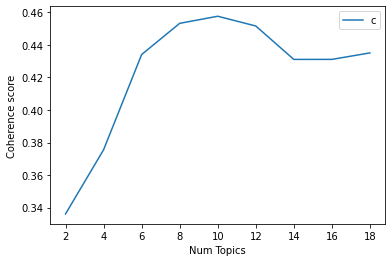

In [84]:
models,coherence=compute_coherence_values(id2word,corpus,trigrams_words,limit=20,start=2,step=2)
x = range(2, 20, 2)
plt.plot(x, coherence)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [85]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [86]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.049*"cluster" + 0.049*"ray" + 0.049*"cold" + 0.049*"front" + 0.029*"black" + 0.029*"around" + 0.029*"hole" + 0.029*"venture" + 0.029*"plunge" + 0.029*"region"'), (1, '0.041*"observation" + 0.040*"hole" + 0.040*"around" + 0.040*"black" + 0.040*"radiation" + 0.040*"strong" + 0.040*"reverberation" + 0.040*"gravity" + 0.040*"accretion" + 0.040*"return"')]


In [87]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=trigrams_words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -4.162381958061208

Coherence Score:  0.33613797439710713


In [88]:
df_topic_sents_keywords = format_topics_sentences(FA_papers['title'].tolist(),ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9829,"cluster, ray, cold, front, black, around, hole...",X-ray Observations of Luminous Dusty Quasars a...
1,1,0.0,0.9920,"cluster, ray, cold, front, black, around, hole...",Venturing beyond the ISCO: Detecting X-ray emi...
2,2,0.0,0.9876,"cluster, ray, cold, front, black, around, hole...",Is there an enormous cold front at the virial ...
3,3,1.0,0.9847,"observation, hole, around, black, radiation, s...",Returning radiation in strong gravity around b...
4,4,1.0,0.9784,"observation, hole, around, black, radiation, s...",AGN-driven galactic outflows: comparing models...
5,5,0.0,0.9891,"cluster, ray, cold, front, black, around, hole...",The interaction between rising bubbles and col...


In [89]:
topic_counts=df_dominant_topic['Dominant_Topic'].value_counts().reset_index().rename(columns={'index':'Topic','Dominant_Topic':'Number of Documents'})
topic_counts['percentage_contribution']=(topic_counts['Number of Documents']/topic_counts['Number of Documents'].sum())*100
topic_counts

,Topic,Number of Documents,percentage_contribution
0,0.0,4,66.666667
1,1.0,2,33.333333


In [90]:
num_topics=2

topic_summaries = []
print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
    print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(lda_model,topic_number=i, topn=10, output=True )
    topic_summaries += [tmp[:5]]
    print

term                 frequency

Topic 0 |---------------------

cluster              0.049
ray                  0.049
cold                 0.049
front                0.049
black                0.029
around               0.029
hole                 0.029
venture              0.029
plunge               0.029
region               0.029
Topic 1 |---------------------

observation          0.041
hole                 0.040
around               0.040
black                0.040
radiation            0.040
strong               0.040
reverberation        0.040
gravity              0.040
accretion            0.040
return               0.040


In [91]:
# topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values


# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Indexed 6 samples in 0.000s...
[t-SNE] Computed neighbors for 6 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.888863


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] KL divergence after 650 iterations: 0.203411


In [92]:
sent_topics_df=pd.DataFrame()
sent_topics_df['Text']=FA_papers['title'].tolist()
sent_topics_df['tsne_x']=tsne_lda[:,0]
sent_topics_df['tsne_y']=tsne_lda[:,1]
sent_topics_df['Topic_No']=topic_num
sent_topics_df=pd.merge(sent_topics_df,df_dominant_topic,on="Text")
sent_topics_df.head()

,Text,tsne_x,tsne_y,Topic_No,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,X-ray Observations of Luminous Dusty Quasars a...,1480.554810,-41.775837,0,0,0.0,0.9829,"cluster, ray, cold, front, black, around, hole..."
1,Venturing beyond the ISCO: Detecting X-ray emi...,532.256348,80.125275,0,1,0.0,0.9920,"cluster, ray, cold, front, black, around, hole..."
2,Is there an enormous cold front at the virial ...,-249.562119,-1556.075317,0,2,0.0,0.9876,"cluster, ray, cold, front, black, around, hole..."
3,Returning radiation in strong gravity around b...,-501.156677,375.377319,1,3,1.0,0.9847,"observation, hole, around, black, radiation, s..."
4,AGN-driven galactic outflows: comparing models...,-48.942532,-624.956909,1,4,1.0,0.9784,"observation, hole, around, black, radiation, s..."


In [93]:
px.scatter(x='tsne_x',y='tsne_y',data_frame=sent_topics_df,color="Topic_No",hover_data=["Topic_Perc_Contrib"])